<a href="https://colab.research.google.com/github/Bhumika0509/Bhumika0509/blob/main/HR_Analysis_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ibm-hr-analytics-attrition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1067%2F1925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T114904Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db1b50fbacfa6043a67c24c08a978bcefce738a9469bbe3d726d7e121b6a2e1a8abc4b7722453ed2f16bb87103fad53d5d952f4d6cfb8089e50fd75d427fff409f45a8c1859c19e844457b4197117705503923308d3dbd28a42403cd617477613ba2b66aa1cfe40fb4f2e2bdd06466ad9aa35a9f8a91712415b37bfdb739d1e87c758845fd239faaca7476347e4f930c0afaae2ca6f16dee4d77dda8483133caef17f8865808165cedc145787966025a00435dcd83af4be8e578e3bd96911b96ddc4282e3124b9344946821afd41256cccac49ca9d18274fcb17249365322734d6289867662df7220695857009f378f05ab9719d151da25f04cbd45b70dae37bf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 51314 bytes downloaded
Downloaded and uncompressed: ibm-hr-analytics-attrition-dataset
Data source import complete.


# 0 - Importing Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df= pd.read_csv("/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# 1 - EDA

In [5]:
df.shape

(1470, 35)

In [6]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [7]:
df.head(30)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,...,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,...,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,...,2,80,2,17,3,2,7,7,7,7


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [9]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [10]:
df.isnull().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [11]:
df.duplicated().sum()

0

## EXPLORING THE TARGET FEATURE

****I chose green for employees who stayed in their jobs and red for those who left. The color red highlights the risk associated with attrition.****

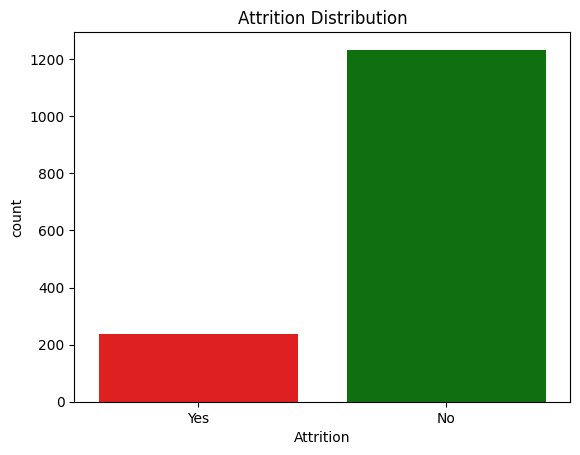

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {'No': 'green', 'Yes': 'red'}

sns.countplot(data=df, x='Attrition', palette=palette)
plt.title('Attrition Distribution')
plt.show()


**here i counted their percentages to validate the visulaiztion by numbers**

In [13]:
print(df['Attrition'].value_counts(normalize=True) * 100)


Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


**i wanted to explore and understand each catergorical feature in my data so i can deeply understand their influnce on the problem of attrition itself**

In [14]:
!pip install plotly


In [15]:
cat_cols = df.select_dtypes(['object']).columns

cat_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [16]:
import pandas as pd
import plotly.express as px

In [17]:
import pandas as pd
import plotly.express as px

def cat_summary(df, col_name, plot=False):
    summary = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    print(summary)

    if plot:
        color_map = {
            'Travel_Rarely': 'plum',
            'Travel_Frequently': 'mediumorchid',
            'Non-Travel': 'darkviolet'
        }

        fig = px.histogram(df, x=col_name, color=col_name,
                           color_discrete_map=color_map,
                           title=f'Distribution of {col_name}',
                           labels={col_name: col_name})
        fig.update_layout(xaxis_title=col_name, yaxis_title='Count')
        fig.show()


## here as we can see we have the BusinessTravel is organized into 3 categories with the most of them rarely travel

In [18]:
col = 'BusinessTravel'
if df[col].dtypes == "bool":
    df[col] = df[col].astype(int)
cat_summary(df, col, plot=True)


                   BusinessTravel      Ratio
BusinessTravel                              
Travel_Rarely                1043  70.952381
Travel_Frequently             277  18.843537
Non-Travel                    150  10.204082


## here as we can see we have the Department is organized into 3 sectors  salse ,research and HR with the sales is the dominant sectors is the employees so its important department to focuse on and improve

In [19]:
col = 'Department'
if df[col].dtypes == "bool":
    df[col] = df[col].astype(int)
cat_summary(df, col, plot=True)


                        Department      Ratio
Department                                   
Research & Development         961  65.374150
Sales                          446  30.340136
Human Resources                 63   4.285714


In [20]:
cat_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

## here as we can see we have the EducationField is divided into into 6 categories with the life sciences (as known as Biology) is the dominant category and the medical being the second which intially makes us predict that the feild that the employess are working i  not the one which they were studing in the univesrity

In [21]:
col = 'EducationField'
if df[col].dtypes == "bool":
    df[col] = df[col].astype(int)
cat_summary(df, col, plot=True)


                  EducationField      Ratio
EducationField                             
Life Sciences                606  41.224490
Medical                      464  31.564626
Marketing                    159  10.816327
Technical Degree             132   8.979592
Other                         82   5.578231
Human Resources               27   1.836735


In [22]:
cat_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

## the most dominate gender of the work force is males which probavly assumes that the attrition ratio would be higher for men than a woman

In [23]:


def cat_summary(df, col_name, plot=False):
    summary = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    print(summary)

    # Plot if specified
    if plot:
        color_map = {
            'Male': '#1f77b4',
            'Female': 'ff69b4'
        }

        fig = px.pie(df, names=col_name, color=col_name,
                     color_discrete_map=color_map,
                     title=f'Distribution of {col_name}')
        fig.update_layout(showlegend=True)
        fig.show()

col = 'Gender'
cat_summary(df, col, plot=True)


        Gender  Ratio
Gender               
Male       882   60.0
Female     588   40.0


In [24]:
cat_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [25]:
import pandas as pd
import plotly.express as px

def cat_summary(df, col_name, plot=False):
    summary = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    print(summary)

    if plot:
        color_map = {
            'Sales Executive': '#006d6d',  # Dark teal
            'Research Scientist': '#009999',  # Medium teal
            'Laboratory Technician': '#00b3b3',  # Light teal
            'Manufacturing Director': '#66cccc',  # Very light teal
            'Healthcare Representative': '#33cccc',  # Light teal
            'Manager': '#004d4d',  # Darker teal
            'Sales Representative': '#4db3b3',  # Medium-light teal
            'Research Director': '#1a8c8c',  # Medium-dark teal
            'Human Resources': '#80e0e0'   # Very light teal
        }

        fig = px.histogram(df, x=col_name, color=col_name,
                           color_discrete_map=color_map,
                           title=f'Distribution of {col_name}',
                           labels={col_name: col_name})
        fig.update_layout(xaxis_title=col_name, yaxis_title='Count')
        fig.show()

col = 'JobRole'
cat_summary(df, col, plot=True)


                           JobRole      Ratio
JobRole                                      
Sales Executive                326  22.176871
Research Scientist             292  19.863946
Laboratory Technician          259  17.619048
Manufacturing Director         145   9.863946
Healthcare Representative      131   8.911565
Manager                        102   6.938776
Sales Representative            83   5.646259
Research Director               80   5.442177
Human Resources                 52   3.537415


In [26]:
cat_cols

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [27]:


def cat_summary(df, col_name, plot=False):
    summary = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    print(summary)

    # Plot if specified
    if plot:
        color_map = {
            'Married': '#2ca02c',  # Green, representing stability and balance
            'Single': '#1f77b4',   # Blue, representing freedom and openness
            'Divorced': '#d62728'  # Red, representing change or disruption
        }

        fig = px.pie(df, names=col_name, color=col_name,
                     color_discrete_map=color_map,
                     title=f'Distribution of {col_name}')
        fig.update_layout(showlegend=True)
        fig.show()

col = 'MaritalStatus'
cat_summary(df, col, plot=True)


               MaritalStatus      Ratio
MaritalStatus                          
Married                  673  45.782313
Single                   470  31.972789
Divorced                 327  22.244898


In [28]:
df['Over18'].unique()

array(['Y'], dtype=object)

#all the over 18 column  contains over 18 employess which does not give us an effitive info about the attrition problem which i see the best to drop it

In [29]:
import pandas as pd
import plotly.express as px

def cat_summary(df, col_name, plot=False):
    # Print summary statistics
    summary = pd.DataFrame({col_name: df[col_name].value_counts(),
                            "Ratio": 100 * df[col_name].value_counts() / len(df)})
    print(summary)

    # Plot if specified
    if plot:
        color_map = {
            'Yes': '#4caf50',  # Green, representing eligibility or approval
            'No': '#f44336'    # Red, representing non-eligibility or restriction
        }

        fig = px.pie(df, names=col_name, color=col_name,
                     color_discrete_map=color_map,
                     title=f'Distribution of {col_name}')
        fig.update_layout(showlegend=True)
        fig.show()

col = 'Over18'
cat_summary(df, col, plot=True)


        Over18  Ratio
Over18               
Y         1470  100.0


In [30]:
df['OverTime'].unique

<bound method Series.unique of 0       Yes
1        No
2       Yes
3       Yes
4        No
       ... 
1465     No
1466     No
1467    Yes
1468     No
1469     No
Name: OverTime, Length: 1470, dtype: object>

In [31]:
#the distribution of attrition over time

In [32]:
def cat_summary(df, col_name, plot=False):
    summary = pd.DataFrame({
        col_name: df[col_name].value_counts(),
        "Ratio": 100 * df[col_name].value_counts() / len(df)
    })
    print(summary)

    if plot:
        color_map = {
            'Yes': '#4caf50',
            'No': '#f44336'
        }

        fig = px.histogram(df, x=col_name, color=col_name,
                           color_discrete_map=color_map,
                           title=f'Distribution of {col_name}')
        fig.update_layout(showlegend=True)
        fig.show()

col = 'OverTime'
cat_summary(df, col, plot=True)


          OverTime     Ratio
OverTime                    
No            1054  71.70068
Yes            416  28.29932


In [33]:
df.describe().info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to max
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       8 non-null      float64
 1   DailyRate                 8 non-null      float64
 2   DistanceFromHome          8 non-null      float64
 3   Education                 8 non-null      float64
 4   EmployeeCount             8 non-null      float64
 5   EmployeeNumber            8 non-null      float64
 6   EnvironmentSatisfaction   8 non-null      float64
 7   HourlyRate                8 non-null      float64
 8   JobInvolvement            8 non-null      float64
 9   JobLevel                  8 non-null      float64
 10  JobSatisfaction           8 non-null      float64
 11  MonthlyIncome             8 non-null      float64
 12  MonthlyRate               8 non-null      float64
 13  NumCompaniesWorked        8 non-null      float64
 14  PercentSalary

#the age column is slightly normally distributed with a slight ski=ewness for the older employess

In [34]:
fig = px.histogram(df, x='Age', title='Distribution of Age')
fig.update_layout(showlegend=False)
fig.show()


#the distance from home here is quitesimiliar between all employees which make it not an effictive info in the determination of attrition

In [35]:
fig = px.histogram(df, x='DistanceFromHome', title='Distribution of DistanceFromHome')
fig.update_layout(showlegend=False)
fig.show()


#here all departments show a range of satisfaction levels, but human resources  have lower satisfaction on average compared to the others, and there is significant variability in responses within the Sales and Research & Development departments which makes it a problem needs to be solved

In [36]:

def plot_violin_plot_by_department(df):
    fig = px.violin(df, x='Department', y='EnvironmentSatisfaction',
                    box=True, points='all',
                    title='Environment Satisfaction by Department')
    fig.update_layout(showlegend=False)
    fig.show()

plot_violin_plot_by_department(df)


#the job involvemnt of Reasearch and development is the biggest which make is it the most important sector in the department to focus on ,then the sales

In [37]:

custom_palette = ['#d3d3d3', '#8a2be2', '#c8a2c8']

job_involvement_fig = px.histogram(df, x='JobInvolvement', color='Department',
                                   color_discrete_sequence=custom_palette,
                                   title='Distribution of Job Involvement by Department',
                                   labels={'JobInvolvement': 'Job Involvement'})
job_involvement_fig.show()


#the satisfation rate across the departments is quiet normal except the HR beeing the least satisfied

In [38]:

color_palette = ['#f28e2b', '#f5b041', '#f9e79f', '#a9dfbf', '#85c1ae']

env_satisfaction_fig = px.histogram(df, x='EnvironmentSatisfaction', color='Department',
                                    color_discrete_sequence=color_palette,
                                    title='Distribution of Environment Satisfaction by Department',
                                    labels={'EnvironmentSatisfaction': 'Environment Satisfaction'})
env_satisfaction_fig.show()


## the gender with the most attretion rate is males

In [39]:

fig = px.histogram(df, x='Gender', color='Attrition',
                   barmode='group',  # This arranges bars side by side
                   category_orders={'Attrition': ['Yes', 'No']},
                   labels={'Attrition': 'Attrition Status'},
                   title='Attrition Distribution by Gender',
                   color_discrete_map={

                       'Yes': 'red',
                       'No': 'gray'
                   })

fig.update_layout(
    xaxis_title='Gender',
    yaxis_title='Count',
    legend_title='Attrition Status'
)

# Show the plot
fig.show()


## he most attrition by travel is the people who travel rarely

In [40]:
import plotly.express as px

def plot_attrition_distribution(df, col):
    color_map = {
        'yes': 'green',
        'no': 'red'
    }

    fig = px.histogram(df, x=col, color='Attrition', barmode='group',
                       color_discrete_map=color_map,  # Apply color mapping
                       labels={col: col, 'count': 'Count'},
                       title=f'Attrition Distribution by {col}')

    total_height = len(df['Attrition'])

    fig.update_layout(
        xaxis_title=col,
        yaxis_title='Count',
        title=f'Attrition Distribution by {col}'
    )

    for i, row in df.groupby([col, 'Attrition']).size().reset_index(name='count').iterrows():
        percentage = '{:.1f}%'.format(100 * row['count'] / total_height)
        fig.add_annotation(
            x=row[col],
            y=row['count'],
            text=percentage,
            showarrow=True,
            arrowhead=2
        )

    fig.show()


In [41]:
plot_attrition_distribution(df, "BusinessTravel")


## the department with the most attrtion is Research and development

In [42]:
plot_attrition_distribution(df, "Department")


## the feild with the most attrition is the biology feild which needs to be focused on

In [43]:
plot_attrition_distribution(df, "EducationField")


## singles are the most ration that leaves work

In [44]:
plot_attrition_distribution(df, "MaritalStatus")


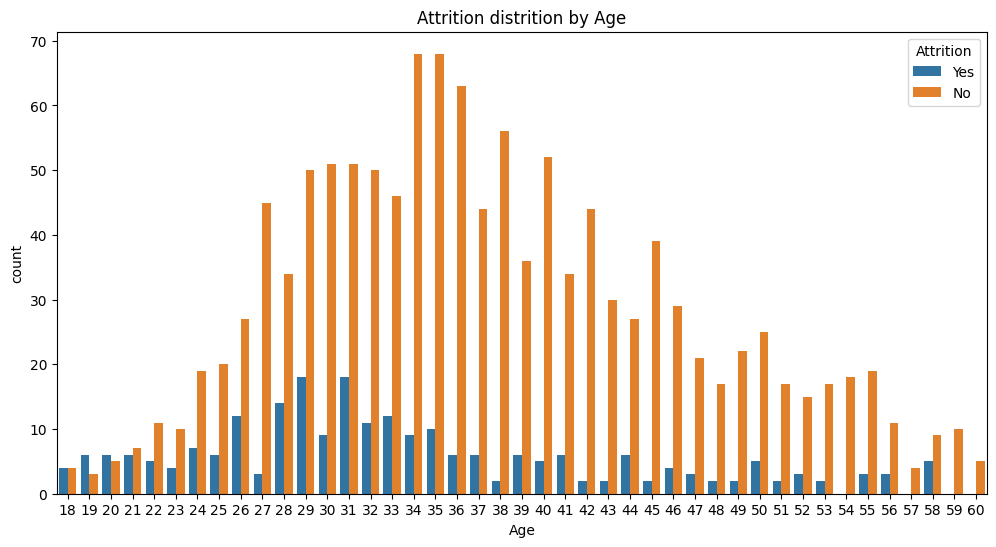

In [45]:
plt.figure(figsize=(12,6))
sns.countplot(x="Age", hue='Attrition', data=df)
plt.title("Attrition distrition by Age" )
plt.show()

## the monthly income by attrition

<Figure size 500x1000 with 0 Axes>

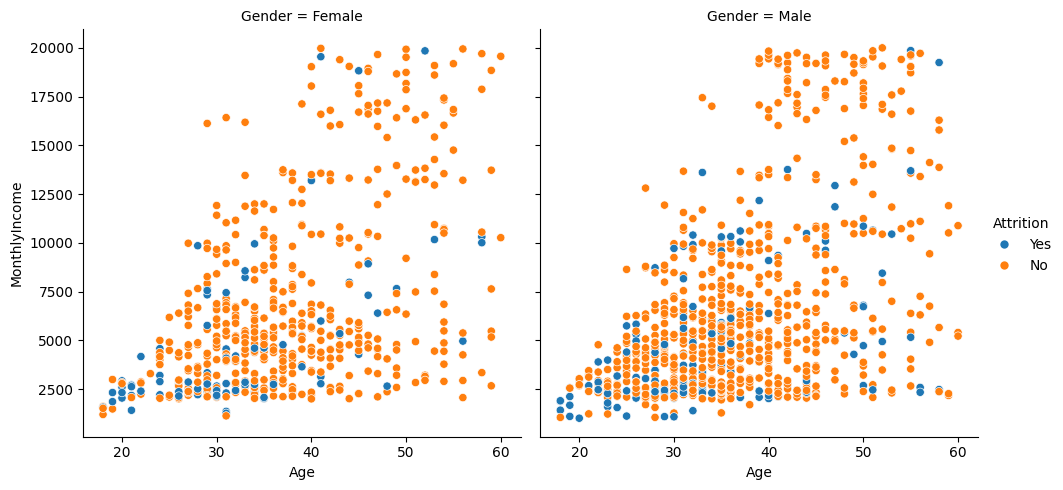

In [46]:
plt.figure(figsize=(5,10))
sns.relplot(data=df,y='MonthlyIncome',x='Age',hue='Attrition',col='Gender')
plt.show()

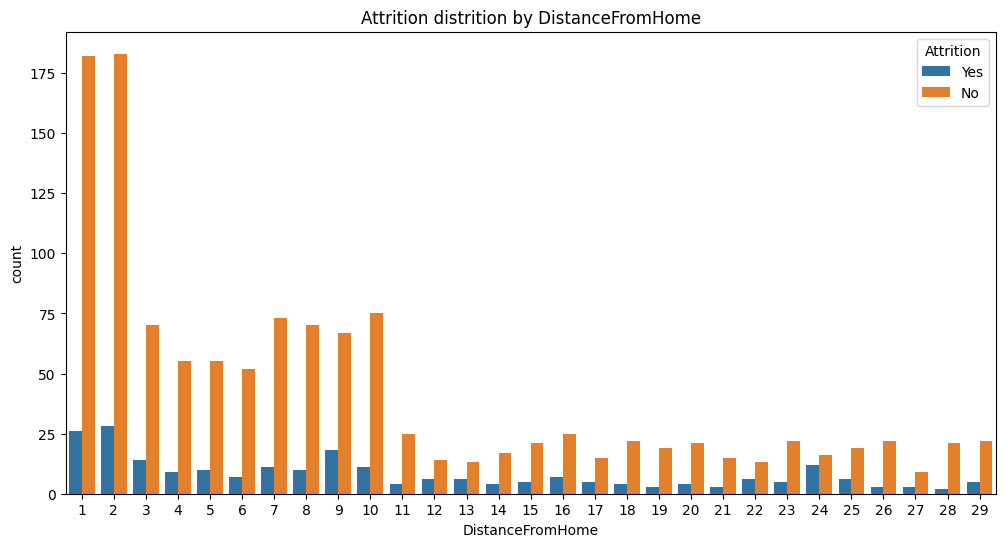

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(x="DistanceFromHome", hue='Attrition', data=df)
plt.title("Attrition distrition by DistanceFromHome" )
plt.show()

# 2 Data Preprocessing

## 2.0 - Splitting the Data

In [48]:
X = df.drop(columns = ['Attrition'])
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

## 2.1 Data Quality Assessment

In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1194 to 1292
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1176 non-null   int64 
 1   BusinessTravel            1176 non-null   object
 2   DailyRate                 1176 non-null   int64 
 3   Department                1176 non-null   object
 4   DistanceFromHome          1176 non-null   int64 
 5   Education                 1176 non-null   int64 
 6   EducationField            1176 non-null   object
 7   EmployeeCount             1176 non-null   int64 
 8   EmployeeNumber            1176 non-null   int64 
 9   EnvironmentSatisfaction   1176 non-null   int64 
 10  Gender                    1176 non-null   object
 11  HourlyRate                1176 non-null   int64 
 12  JobInvolvement            1176 non-null   int64 
 13  JobLevel                  1176 non-null   int64 
 14  JobRole                   

## 2.2 Data Preprocessing Pipeline

In [50]:
# Specify the features to drop
features_to_drop = ['Over18', 'EmployeeNumber', 'EmployeeCount', 'EducationField']

# Drop features from X_train and X_test
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)


# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('standard_scaler', StandardScaler()),  # First, standardize
            ('min_max_scaler', MinMaxScaler())      # Then, apply min-max scaling
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

## 2.3 -Preprocessing the Target

In [51]:
class TargetMapper(BaseEstimator, TransformerMixin):
    def fit(self, y, *_):
        return self

    def transform(self, y):
        return y.map({'Yes': 1, 'No': 0})

# Preprocess the target variable y
target_mapper = TargetMapper()
y_train_processed = target_mapper.fit_transform(y_train)
y_test_processed = target_mapper.transform(y_test)

# 3 - Learning and Predicting

## 3.1 - Logistic Regression

Accuracy: 0.8809523809523809
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       247
           1       0.73      0.40      0.52        47

    accuracy                           0.88       294
   macro avg       0.81      0.69      0.73       294
weighted avg       0.87      0.88      0.87       294



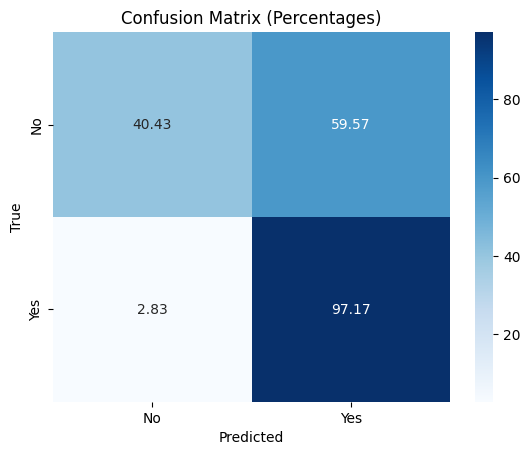

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression model
log_reg = LogisticRegression(class_weight={0: 1, 1: 1}, max_iter=1000)

# Fit the model to the training data
log_reg.fit(X_train_processed, y_train_processed)

# Make predictions on the test data
y_pred = log_reg.predict(X_test_processed)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_processed, y_pred))
print(classification_report(y_test_processed, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test_processed, y_pred, labels=[1, 0])

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap for the percentage confusion matrix
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

## 3.2 - KNN

### 3.2.1 - Initializing the Model

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
# Train the model
knn.fit(X_train_processed, y_train_processed)

KNeighborsClassifier(weights='distance')

### 3.2.2 - Predicting and Evaluating

In [54]:
# Make predictions
y_pred = knn.predict(X_test_processed)
# Evaluate the model
accuracy = accuracy_score(y_test_processed, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test_processed, y_pred))


Accuracy: 84.35%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       247
           1       0.53      0.19      0.28        47

    accuracy                           0.84       294
   macro avg       0.70      0.58      0.60       294
weighted avg       0.81      0.84      0.81       294



**Comment**: The model is very good at predicting non-leavers (about 100%), but is *terrible* at predicting leavers (8%).<br>
This is a cause for concern because predicting an employee leaving is more important.

**Analysis**: This is probably due to the fact the attritioning employees are underrepresented in the data (around 16% of employees).

## 3.3 SVM Classifier

In [55]:
# Define a range of gamma values to try
gamma_values = np.logspace(-3, 0, 6)  # Values from 0.001 to 10
accuracies = []
recalls = []

# Loop through each gamma value
for gamma in gamma_values:
    # Create and fit the SVM model
    svm_model = SVC(
        class_weight='balanced',
        kernel='poly',
        gamma=gamma,
        max_iter=20000
    )
    svm_model.fit(X_train_processed, y_train_processed)

    # Make predictions
    y_pred = svm_model.predict(X_test_processed)

    # Record accuracy and recall
    accuracies.append(accuracy_score(y_test_processed, y_pred))
    recalls.append(recall_score(y_test_processed, y_pred))

# Find the best gamma based on accuracy
best_accuracy_index = np.argmax(accuracies)
best_accuracy_gamma = gamma_values[best_accuracy_index]
best_accuracy = accuracies[best_accuracy_index]

# Find the best gamma based on recall
best_recall_index = np.argmax(recalls)
best_recall_gamma = gamma_values[best_recall_index]
best_recall = recalls[best_recall_index]

# Plotting gamma vs accuracy and recall using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=gamma_values, y=accuracies, mode='lines+markers', name='Accuracy', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=gamma_values, y=recalls, mode='lines+markers', name='Recall', line=dict(color='orange')))

# Update layout
fig.update_layout(
    title='Gamma vs Accuracy and Recall',
    xaxis=dict(title='Gamma (RBF Kernel Parameter)'),
    yaxis=dict(title='Score'),
    xaxis_type='log',  # Use log scale for gamma values
    showlegend=True
)

# Show the plot
fig.show()

# Output the best gamma values
print(f"Best gamma for accuracy: {best_accuracy_gamma} with accuracy: {best_accuracy}")
print(f"Best gamma for recall: {best_recall_gamma} with recall: {best_recall}")


Best gamma for accuracy: 1.0 with accuracy: 0.826530612244898
Best gamma for recall: 0.001 with recall: 1.0


Accuracy: 0.7721088435374149
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       247
           1       0.39      0.72      0.50        47

    accuracy                           0.77       294
   macro avg       0.66      0.75      0.68       294
weighted avg       0.85      0.77      0.80       294



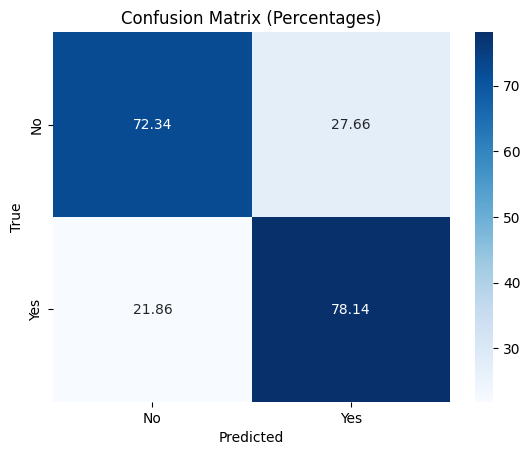

In [56]:
# Create an SVM model with specified class weights, kernel, and gamma
svm_model = SVC(
    class_weight='balanced',  # Handle class imbalance
    kernel='poly',             # Using Poly kernel
    gamma= 0.063,            # Set gamma (try 'scale', 'auto', or a specific float value)
    max_iter=20000             # Maximum iterations for convergence
)

# Fit the model to the training data
svm_model.fit(X_train_processed, y_train_processed)

# Make predictions and evaluate as before
y_pred = svm_model.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test_processed, y_pred))
print(classification_report(y_test_processed, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test_processed, y_pred, labels=[1, 0])
# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Create a heatmap for the percentage confusion matrix
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

## 3.4 - Naive Bayesan Classifier

Accuracy: 63.95%

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.74       247
           1       0.27      0.77      0.40        47

    accuracy                           0.64       294
   macro avg       0.60      0.69      0.57       294
weighted avg       0.83      0.64      0.69       294



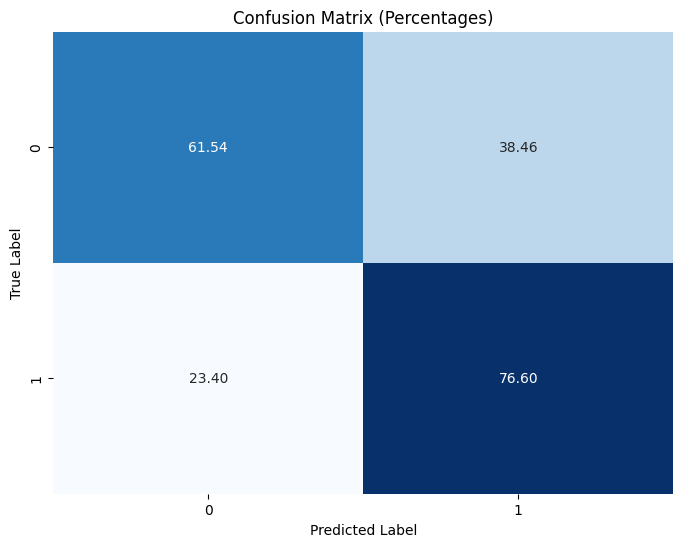

In [57]:
# Create a Naive Bayes classifier
nb_classifier = GaussianNB()  # Prior probability for class 0 is 0.3, for class 1 is 0.7

# Fit the model to the training data
nb_classifier.fit(X_train_processed, y_train_processed)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_processed)

# Evaluate the model
accuracy = accuracy_score(y_test_processed, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test_processed, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_processed, y_pred)

# Convert confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 3.5 - Democracy (Model Voting)

We let each model make its predictions, then we see which class got the most predictions by the four models.
If classes are tied (2 vs 2), we give the vote to whichever class the SVM predicted (because of its high performance)

In [58]:
y_pred_svm = svm_model.predict(X_test_processed)
y_pred_log_reg = log_reg.predict(X_test_processed)
y_pred_knn = knn.predict(X_test_processed)
y_pred_nb = nb_classifier.predict(X_test_processed)

predictions_df = pd.DataFrame({
    'SVM': y_pred_svm,
    'LogReg': y_pred_log_reg,
    'KNN': y_pred_knn,
    'NaiveBayes': y_pred_nb
})

# Voting function
def majority_voting(row):
    # Count the votes for each class
    votes = row.value_counts()

    # If majority agrees, return that prediction
    if votes.max() >= 3:
        return votes.idxmax()

    # If tie, return the SVM's prediction
    return row['SVM']

# Apply the voting function across all rows
y_pred_voting = predictions_df.apply(majority_voting, axis=1)

# Evaluate the voting-based classifier
print("Accuracy of Voting Classifier:", accuracy_score(y_test_processed, y_pred_voting))
print(classification_report(y_test_processed, y_pred_voting))

Accuracy of Voting Classifier: 0.7959183673469388
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       247
           1       0.41      0.64      0.50        47

    accuracy                           0.80       294
   macro avg       0.67      0.73      0.69       294
weighted avg       0.84      0.80      0.81       294



In [59]:
# Weights for each model (e.g., give SVM more weight)
weights = {
    'SVM': 2,         # SVM has a weight of 3
    'LogReg': 2,      # Logistic Regression has a weight of 1
    'KNN': 2,         # KNN has a weight of 1
    'NaiveBayes': 1   # Naive Bayes has a weight of 1
}

# Weighted voting function
def weighted_voting(row):
    # Dictionary to accumulate weighted votes
    weighted_votes = {0: 0, 1: 0}

    # For each model, add its weighted vote
    for model, weight in weights.items():
        prediction = row[model]
        weighted_votes[prediction] += weight

    # Return the class with the highest weighted vote
    if weighted_votes[1] > weighted_votes[0]:
        return 1
    elif weighted_votes[0] > weighted_votes[1]:
        return 0
    else:
        # In case of tie, return the SVM's prediction
        return row['LogReg']

# Apply the weighted voting function across all rows
y_pred_weighted_voting = predictions_df.apply(weighted_voting, axis=1)

# Evaluate the weighted voting classifier
print("Accuracy of Weighted Voting Classifier:", accuracy_score(y_test_processed, y_pred_weighted_voting))
print(classification_report(y_test_processed, y_pred_weighted_voting))


Accuracy of Weighted Voting Classifier: 0.8605442176870748
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       247
           1       0.59      0.40      0.48        47

    accuracy                           0.86       294
   macro avg       0.74      0.68      0.70       294
weighted avg       0.85      0.86      0.85       294

